In [87]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [89]:
# Read in our image and ROI image
img_ds = gdal.Open('data/example/LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('data/example/training_data.gtif', gdal.GA_ReadOnly)

In [11]:
img_ds.RasterYSize

250

In [13]:
img_ds.RasterXSize

250

In [15]:
img_ds.RasterCount

8

In [21]:
gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)

numpy.int16

In [7]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
img.shape

(250, 250, 8)

In [9]:
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [25]:
img

array([[[ 569,  886,  758, ...,  988, 2686,    0],
        [ 526,  886,  758, ...,  988, 2686,    0],
        [ 569,  798,  776, ...,  961, 2686,    0],
        ...,
        [ 311,  452,  356, ...,  780, 2487,    0],
        [ 289,  452,  297, ...,  647, 2487,    0],
        [ 311,  430,  337, ...,  674, 2436,    0]],

       [[ 568,  886,  815, ..., 1014, 2686,    0],
        [ 589,  929,  853, ..., 1014, 2686,    0],
        [ 568,  907,  910, ..., 1014, 2686,    0],
        ...,
        [ 267,  430,  318, ...,  674, 2487,    0],
        [ 332,  452,  337, ...,  594, 2487,    0],
        [ 332,  452,  395, ...,  727, 2487,    0]],

       [[ 546,  864,  834, ...,  988, 2637,    0],
        [ 525,  886,  834, ...,  988, 2637,    0],
        [ 589,  928,  891, ...,  988, 2637,    0],
        ...,
        [ 311,  452,  356, ...,  727, 2487,    0],
        [ 311,  475,  395, ...,  727, 2487,    0],
        [ 311,  475,  356, ...,  753, 2487,    0]],

       ...,

       [[ 499,  851,  76

In [23]:
img.shape

(250, 250, 8)

In [35]:
roi_ds.RasterYSize

250

In [37]:
roi_ds.RasterXSize

250

In [39]:
roi_ds.RasterCount

1

In [91]:
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
roi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [43]:
img[:, :, 4]

array([[2234, 2160, 2085, ..., 1766, 1564, 1590],
       [2184, 2184, 2234, ..., 1564, 1489, 1665],
       [2161, 2210, 2260, ..., 1691, 1766, 1817],
       ...,
       [2546, 2773, 2873, ..., 1791, 1817, 1918],
       [2722, 2823, 2748, ..., 1438, 2219, 2345],
       [2823, 2873, 2773, ..., 2294, 2597, 2294]], dtype=int16)

In [45]:
img[:, :, 4].shape

(250, 250)

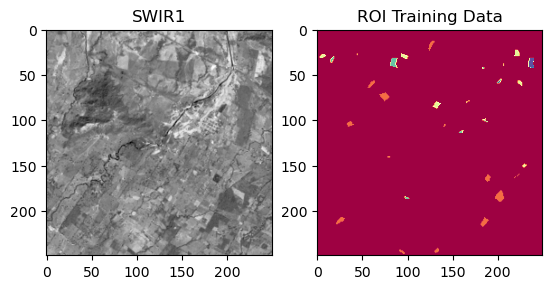

In [41]:
# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [47]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

We have 718 samples


In [49]:
# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

The training data include 5 classes: [1 2 3 4 5]


In [51]:
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

Our X matrix is sized: (718, 8)
Our y array is sized: (718,)


In [57]:
X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

In [59]:
X.shape

(718, 7)

In [61]:
y.shape

(718,)

In [63]:
print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

After masking, our X matrix is sized: (718, 7)
After masking, our y array is sized: (718,)


In [65]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [67]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 98.32869080779945%


In [69]:
bands = [1, 2, 3, 4, 5, 7, 6]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.13030789282305655
Band 2 importance: 0.20079870746967288
Band 3 importance: 0.1132042579505258
Band 4 importance: 0.09526715677607496
Band 5 importance: 0.2005528933484553
Band 7 importance: 0.17854687617322124
Band 6 importance: 0.08132221545899333


In [71]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict    1   2    3    4   5  All
truth                              
1        383   0    0    0   0  383
2          0  16    0    0   0   16
3          0   0  145    0   0  145
4          0   0    0  106   0  106
5          0   0    0    0  68   68
All      383  16  145  106  68  718


In [79]:
import geopandas as gpd

In [81]:
shape_file = "../data/land_cover/cop/CLC18_IE/CLC18_IE.shp"

In [85]:
gdf = gpd.read_file(shape_file)
gdf

,OBJECTID,ID,CODE_18,Class_Desc,Area_Ha,Shape_STAr,Shape_STLe,geometry
0,1,IE_1,111,Continuous urban fabric,3.593744e+01,3.595292e+05,3.399929e+03,"POLYGON ((149105.431 55190.742, 149111.973 551..."
1,2,IE_2,111,Continuous urban fabric,1.785159e+02,1.785928e+06,9.115961e+03,"POLYGON ((167787.511 72255.465, 167802.928 722..."
2,3,IE_3,111,Continuous urban fabric,2.767229e+01,2.768421e+05,3.185437e+03,"POLYGON ((210988.216 77233.553, 210981.346 772..."
3,4,IE_4,111,Continuous urban fabric,4.389431e+01,4.391323e+05,3.740968e+03,"POLYGON ((96773.475 91139.256, 96755.145 91047..."
4,5,IE_5,111,Continuous urban fabric,5.020679e+01,5.022843e+05,3.335530e+03,"POLYGON ((155736.979 98850.382, 155742.712 988..."
...,...,...,...,...,...,...,...,...
18877,18878,IE_18878,522,Estuaries,5.021254e+01,5.023418e+05,5.987252e+03,"POLYGON ((179990.737 427199.806, 180063.404 42..."
18878,18879,IE_18879,522,Estuaries,1.747832e+02,1.748585e+06,1.643064e+04,"POLYGON ((209180.776 434018.782, 209185.396 43..."
18879,18880,IE_18880,522,Estuaries,8.743091e+01,8.746859e+05,9.344419e+03,"POLYGON ((192146.995 434024.284, 192149.205 43..."
18880,18881,IE_18881,522,Estuaries,2.865799e+02,2.867034e+06,1.934943e+04,"POLYGON ((242831.332 451792.090, 242834.979 45..."
